# Model Experiments

In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm.auto import tqdm
import math
#torch.manual_seed(0)
#np.random.seed(0)
#torch.set_deterministic(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


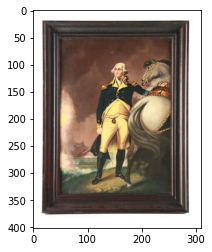

In [ ]:
plt.imshow(PIL.Image.open("/content/drive/My Drive/CPEN 291/project/data/liveauctioneer_101.jpg"))

In [ ]:
im = PIL.Image.open("/content/drive/My Drive/CPEN 291/project/data/christies_2.jpg")
len(im.split())

3

In [3]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [42]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [5]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [ ]:
dataset_tmp = PricePredictionDataset(dataset_dir)

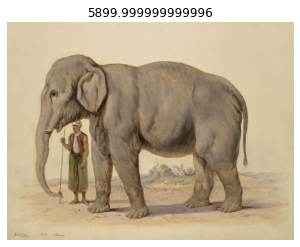

In [ ]:
show_img_price(dataset_tmp[78])

4726


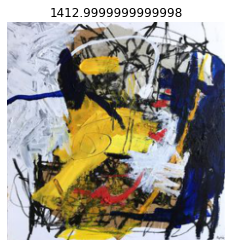

In [43]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
dataset_full= PricePredictionDataset(dataset_dir, transform=xform)
print(len(dataset_full))
show_img_price(dataset_full[102])

In [44]:
n_all= len(dataset_full)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train), len(dataset_test)

(3780, 946)

In [45]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [80]:
pt = True
trim = False
model= torchvision.models.resnet18(pretrained=pt) # complicated models tend to overfit
print(model.fc.in_features) # fc for resnet
#print(model.classifier.in_features) # classifier for densenet
#print(model.classifier[-1].in_features) # classifier[-1] for vgg

#for param in model.parameters():
#  param.requires_grad = False # freeze pretrained layers, otherwise it tends to overfit quickly

# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

# from https://discuss.pytorch.org/t/reset-model-weights/19180/4
def weights_init(m):
  if isinstance(m, torch.nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight.data)

if (not pt):
  model.apply(weights_init)
  for child in model.children():
    child.apply(weights_init)
    for c in child.children():
      c.apply(weights_init)
      for h in c.children():
        h.apply(weights_init)
        for i in h.children():
          i.apply(weights_init)


model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1),
    #torch.nn.Linear(128, 1),

#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, 1)
)
torch.nn.init.xavier_uniform_(model.fc[0].weight)
#torch.nn.init.xavier_uniform_(model.fc[2].weight)
#torch.nn.init.xavier_uniform_(model.classifier[-1][4].weight)
#torch.nn.init.xavier_uniform_(model.classifier[6].weight)
#torch.nn.init.xavier_uniform_(model.classifier[8].weight)
#torch.nn.init.xavier_uniform_(model.classifier[10].weight)


device = torch.device('cuda:0')
model.to(device);


512


In [82]:
criterion = torch.nn.MSELoss()
# For pretrained
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# For untrained
if (not pt):
  criterion_start = torch.nn.L1Loss() # MSELoss is too great at first for untrained NN, loss ends up being nan
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.1) #, weight_decay=0.1)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

In [55]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    with torch.enable_grad():
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            opt.zero_grad()
            outs = model(samples)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              print("loss nan")
              print(loss)
    sched.step()
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

# Use L1loss to train the model until the loss is low enough to use MSEloss # not used
def marathon(model, criterion0, criterion, optimizer, scheduler, n_epochs):
    crit = criterion0
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, crit, optimizer, scheduler)
        loss_test, _ = run_test(model, crit, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
        if (loss_train < 0.1 and loss_test < 0.1):
          crit = criterion
    return loss_test


In [83]:
run_all(model, criterion, optimizer, scheduler, 10)

epoch 1: train loss 4.5805, test loss 1.6172


epoch 2: train loss 1.3509, test loss 5.0666


epoch 3: train loss 1.3609, test loss 1.6359


epoch 4: train loss 1.2956, test loss 1.3338


epoch 5: train loss 1.2683, test loss 1.3440


epoch 6: train loss 1.2608, test loss 2.9110


epoch 7: train loss 1.2368, test loss 1.3331


epoch 8: train loss 1.2374, test loss 1.3309


epoch 9: train loss 1.2383, test loss 1.3225


epoch 10: train loss 1.2318, test loss 1.3663



tensor(1.3663, device='cuda:0')

In [ ]:
model

| model | fc | optim | test loss (1/5 data) | overfitted (1/5 data) | test loss (all data) | overfitted (all data)
| --- | --- |  --- |  --- | --- | --- | --- |
resnet18 | 1 linear |  SGD, wd = 0.01 |  0.4 | yes | 1.18 | yes
resnet18 | 1 linear | SGD, wd = 0.1 |  0.4 | yes
resnet18 | 1 linear | SGD, wd = 1 |   | | 1-2 | no but not even fitted
resnet18 | 2 linear + relu | SGD, wd = 0.1 |  0.5 | yes
resnet18 (without layers 3 and 4) | 1 linear |  SGD, wd = 0.1 | 0.38 | no | 1.18 | no
resnet34 | 1 linear | SGD, wd = 0.1 | 0.38 | yes | 1.22 | yes
resnet34 (w/o layers 3,4) | 1 linear | SGD, wd = 0.1 | 0.38 | yes | 1.19 | no 
resnet34 | 2 linear + relu | SGD, wd = 0.1 | 0.48 | yes
resnet50 | 1 linear | SGD, wd = 0.1 | 0.42 | yes
resnet101 | 1 linear | SGD, wd = 0.1 | 0.47 | maybe
resnet152 | 1 linear | SGD, wd = 0.1 | 0.4 | yes | 1.26 | going to
resnet152 (frozen) | 5 linear + relu |  SGD, default | 0.7 | no
resnet152 (frozen) | 5 linear + relu + dropout |  SGD, default | 0.8 (slow) | no
resnet152 (frozen) | 5 linear + relu |  AdamW, default | 0.8 | no
densenet121 | 3 linear + relu | SGD, wd = 0.1 | 0.43 | yes
densenet121 | 3 linear + relu | SGD, wd = 0.01 | 0.5 | yes
densenet121 (frozen) | 5 linear + relu | SGD, wd = 0.1 | 0.64 |  no
densenet121 (frozen) | 6 linear + relu | SGD, wd = 0.1 | 0.64 |  no
densenet121 (frozen) | 2 linear + relu | SGD, wd = 0.1 | 0.7 |  no 
vgg11_bn | 3 linear + relu | SGD, wd = 0.1 | 0.7 | no
vgg11_bn | 1 linear | SGD, wd = 0.1 | 0.5 | no
vgg13_bn | 1 linear | SGD, wd = 0.1 | 0.5 | no
vgg16_bn | 1 linear | SGD, wd = 0.1 | 0.45 | no



complicated models overfit if not frozen

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/simpleModel.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/simpleModel.pth'))
model.eval()

In [79]:
test_loss, test_preds= run_test(model, criterion)
print(test_loss)

tensor(1.4410, device='cuda:0')


In [77]:
test_preds[0]

tensor([8.3090])

Prediction     | Real Price


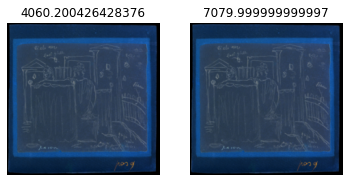

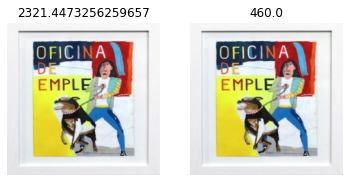

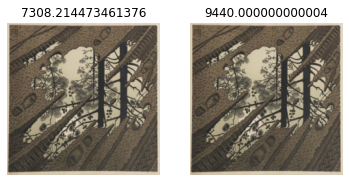

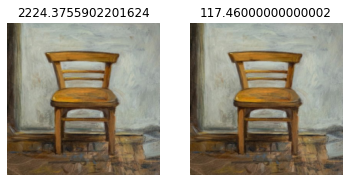

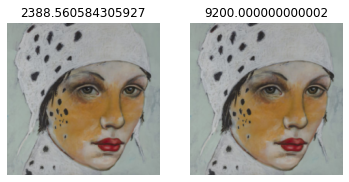

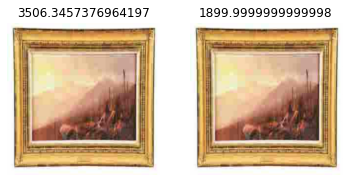

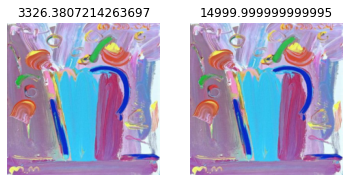

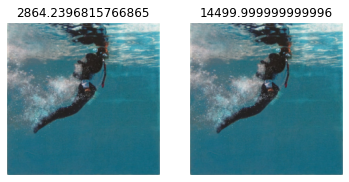

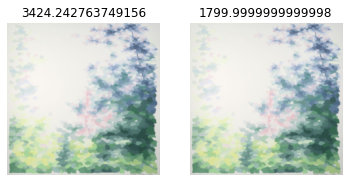

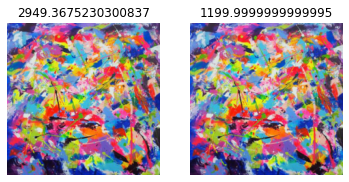

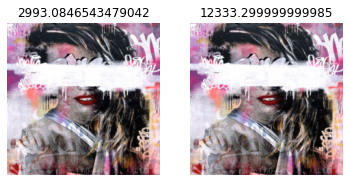

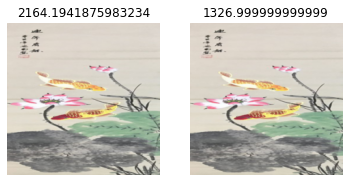

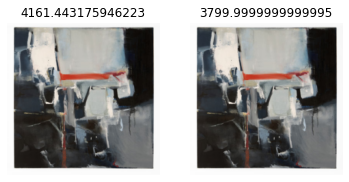

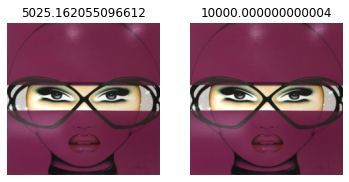

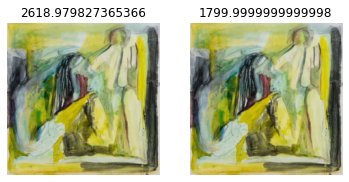

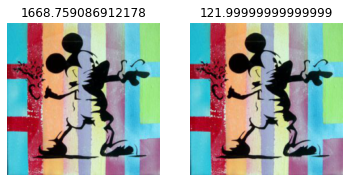

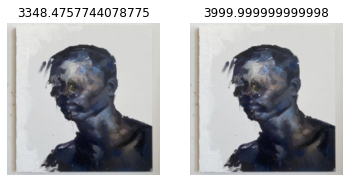

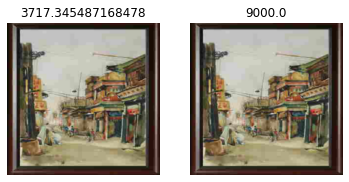

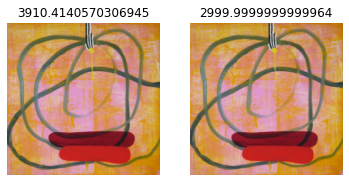

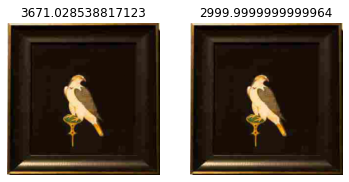

In [68]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price((dataset_test[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price(dataset_test[i])
    plt.show(block=True)
